In [41]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [42]:
env = BlackjackEnv()

In [43]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [44]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    # return deterministic policy
    def deterministic_policy(Q_vals):
        deter = np.zeros(Q_vals.shape)
        deter[np.argmax(Q_vals)] = 1
        return deter
    
    deterministic_matrix = {k: deterministic_policy(v) for k, v in Q.items()}
    
    def policy_fn(observation):
        return deterministic_matrix[observation]
    return policy_fn
#print create_greedy_policy(np.random.random((12,3,4,6,6)))

In [105]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    states = []
    start = []
    target_policy = create_greedy_policy(Q)
    iterations = 0
    while iterations < num_episodes:
        episode = []
        s = env.reset()
        is_done = False
        while is_done == False:
            action = np.random.choice(range(env.action_space.n), p=behavior_policy(s))
            new_s, r, is_done, _ = env.step(action)
            episode.append((s,action,r))
            s = new_s
        G = 0.0
        W = 1.0
        for state,action,reward in episode[::-1]:
            G = discount_factor*G + reward
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            target_policy = create_greedy_policy(Q)
            if action != np.random.choice(range(env.action_space.n), p=target_policy(state)):
                break
            # using a deterministic policy so π(a|s) is always 1
            W = W * (1. / behavior_policy(state)[action])
        iterations += 1
        
    return Q, target_policy

In [106]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

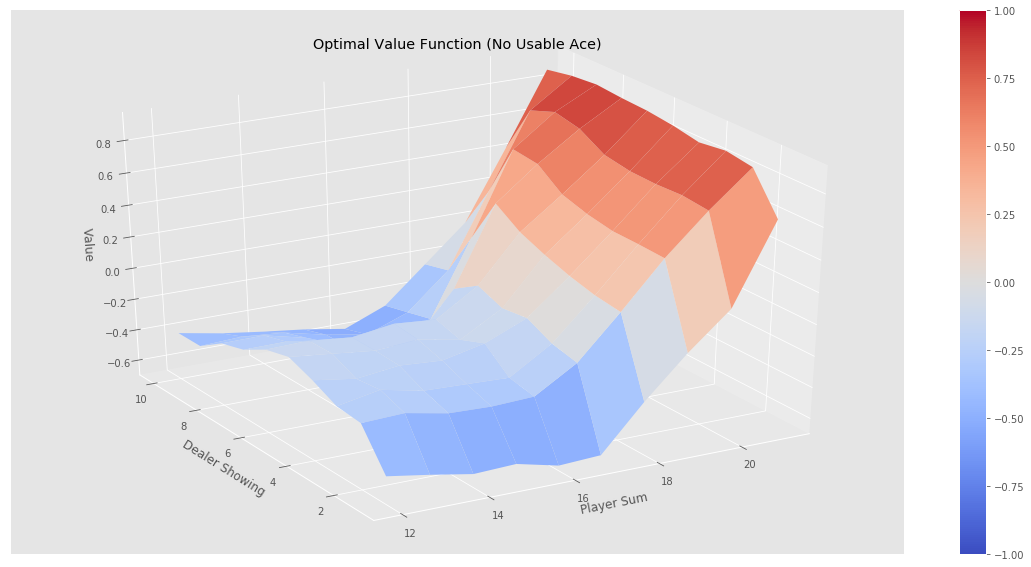

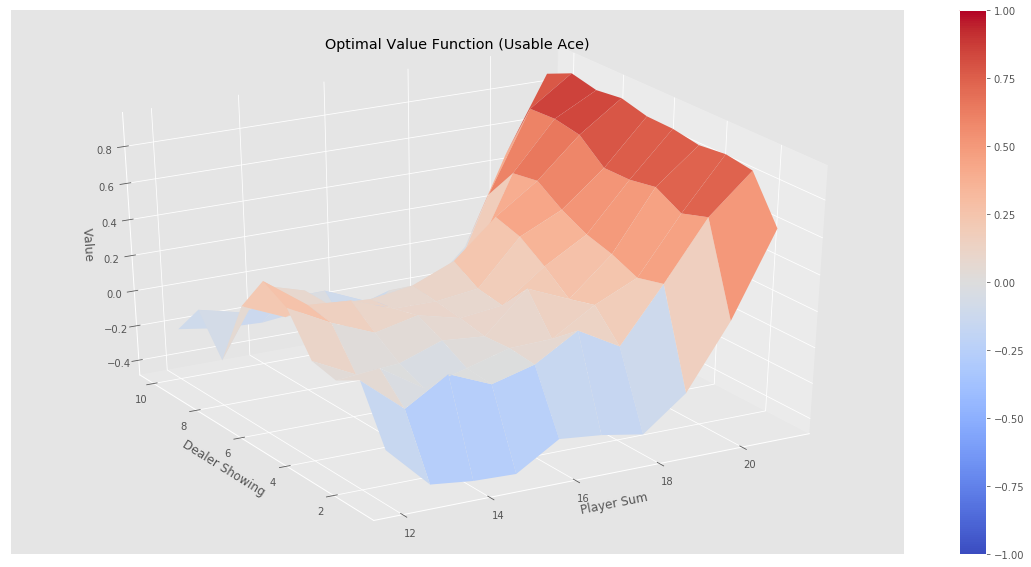

In [102]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")